In [1]:
from datetime import datetime,timedelta
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from xmitgcm import open_mdsdataset
from MITgcmutils import rdmds, wrmds
import pych.ecco as pe
import ecco_v4_py as ecco
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import matplotlib.ticker as ticker
from matplotlib import rc
from scipy import stats

from pych.plot import nice_inward_ticks

In [2]:
plt.rcParams.update({'font.size':18,'axes.labelsize':18,'axes.titlesize':22,'text.usetex':True})
rc('text.latex', preamble=r'\usepackage{color}')

### Load up the ECCO output files and make dataset

In [6]:
# messed up the mask sign...
uvel = -np.squeeze(rdmds('../mdsfiles/euc_out.02.0000000001'))
vvel = -np.squeeze(rdmds('../mdsfiles/euc_out.03.0000000001'))

In [7]:
ntime = len(uvel)
ecco_time = np.array([np.datetime64(x) for x in datetime(1992,1,1,12)+(np.arange(ntime)+1)*timedelta(hours=1)])

In [8]:
eds = xr.Dataset()
eds['time'] = xr.DataArray(ecco_time,coords={'time':ecco_time},dims=('time',))

In [9]:
eds['uvel'] = xr.DataArray(100*uvel,coords=eds.time.coords,dims=eds.time.dims,
                          attrs={'description':'Hourly Zonal Velocity',
                                 'Depth':'75m',
                                 'lon':'140W',
                                 'lat':'Averaged between 2 grid cells at ~.2 N/S',
                                 'units':'cm/s'})
eds['vvel'] = xr.DataArray(100*vvel,coords=eds.time.coords,dims=eds.time.dims,
                          attrs={'description':'Hourly Zonal Velocity',
                                 'Depth':'75m',
                                 'lon':'Averaged between 2 grid cells at 139.5W and 140.5W ',
                                 'lat':'0N',
                                 'units':'cm/s'})

### Load up ADCP dataset

In [18]:
adcp = xr.open_dataset('/mnt/data/datasets/tao_triton/adcp0n140w_hr.cdf')
tslice = slice('1996-09-01','2000-01-01')
adcp = adcp.sel(lon=220,lat=0,depth=75).sel(time=tslice)
adcp = adcp.rename({'u_1205':'uvel','v_1206':'vvel'})

In [76]:
adcp.time[0]

<xarray.DataArray 'time' ()>
array('1996-09-04T01:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 1996-09-04T01:00:00
    depth    float32 75.0
    lat      float32 0.0
    lon      float32 220.0
Attributes:
    FORTRAN_format:  
    type:            EVEN
    point_spacing:   even

In [19]:
def replace_nans(ds,fld):
    ds[fld] = xr.where(ds[fld]==ds.missing_value,np.NAN,ds[fld])
    return ds[fld]

In [20]:
for f in adcp.data_vars:
    adcp[f] = replace_nans(adcp,f)

In [21]:
fake_for_xaxis = xr.where(np.isnan(adcp.uvel),0.,adcp.uvel)

In [22]:
tablestuff=[]
for fld in ['uvel','vvel']:
    # do some computations for table
    diff_squared = (adcp[fld]-eds[fld])**2
    Nt = (adcp.time==eds.time).sum()
    comps =  ['%.2f' % adcp[fld].mean().values,
              '%.2f' % adcp[fld].min().values,
              '%.2f' % adcp[fld].max().values,
              '%.2f' % adcp[fld].std().values,
              '%.2f' % stats.skew(adcp[fld].values,nan_policy='omit').data,
              '%.2f' % stats.kurtosis(adcp[fld].values,nan_policy='omit'),
              '%.2f' % np.sqrt( diff_squared.sum()/Nt )] # last for RMSD ... coming soon
    tablestuff.append(comps)

In [70]:
plt.rcParams.update({'lines.linewidth':1.5})

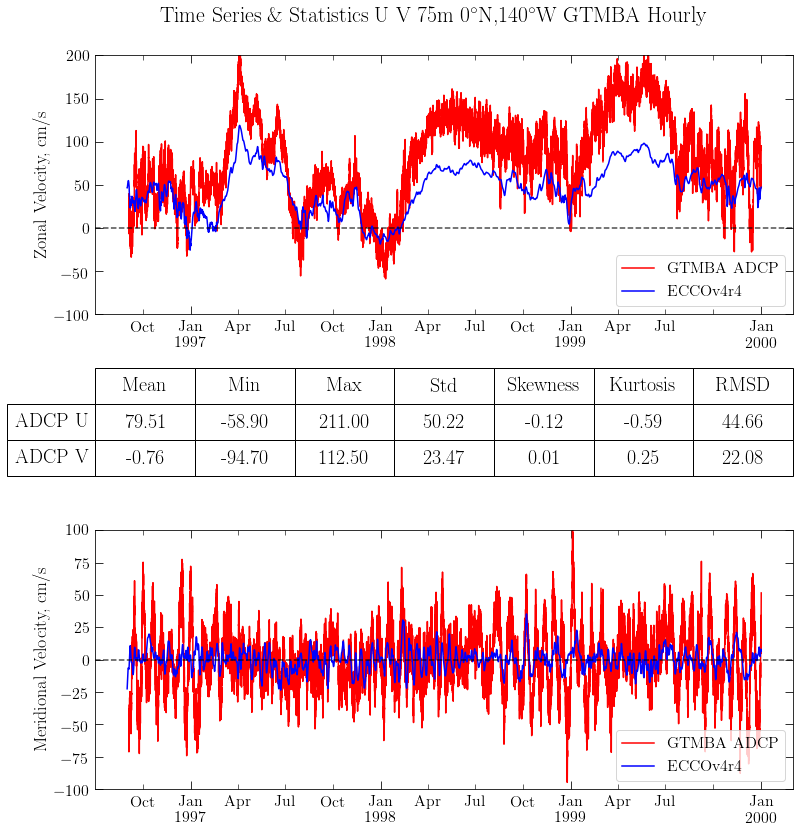

In [72]:
fig,axs = plt.subplots(3,1,figsize=(6.25*2,2.25*6),
                       gridspec_kw={
                           'height_ratios': [2,1, 2]})

for fld,ax,lbl,ylim in zip(['uvel','vvel'],
                           axs[[0,2]],
                           ['Zonal Velocity, cm/s','Meridional Velocity, cm/s'],
                          [[-100,200],[-100,100]]):
    adcp[fld].plot(ax=ax,color='red',label='GTMBA ADCP')
    eds[fld].sel(time=tslice).plot(ax=ax,color='blue',label='ECCOv4r4')

    # add line at y=0
    ax.axhline(y=0,alpha=.7,color='black',linestyle='--')
    
    # Plot formatting
    ax.set(xlabel='',ylabel=lbl,
           ylim=ylim,#xlim=["1996-01-01","1998-12-31"],
           title='')

    # Date formatting for x-axis
    date_form = DateFormatter("%b \n%Y")
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonth=[4,7,10]))
    ax.xaxis.set_major_formatter(date_form)
    
    ax.tick_params(direction='in',which='major',length=8,top=True,right=True,pad=6)
    ax.tick_params(direction='in',which='minor',length=5,top=True,right=True,pad=6)
    ax.legend(loc='lower right')
    ax.set_xticklabels(['Oct','Apr','Jul']*3,minor=True)
    for label in ax.xaxis.get_ticklabels():
        label.set_horizontalalignment('center')
        label.set_rotation(0)
    
columns = ['Mean','Min','Max','Std','Skewness','Kurtosis','RMSD']
table = axs[1].table(tablestuff,
             rowLabels=['ADCP U','ADCP V'],colLabels=columns,
             loc='center',rowLoc='center',cellLoc='center')
#[ax.set(xlim=['1996-02-02','1998-12-31']) for ax in axs[[0,2]]]
axs[1].axis('off')
table.set_fontsize(20)
table.scale(1, 3)

fig.suptitle(r'Time Series \& Statistics U V 75m 0$^\circ$N,140$^\circ$W GTMBA Hourly',y=.93);
fig.savefig('../figures/adcp_eccov4r4_hourly_140w_75m_1996-2000.png')

<xarray.DataArray 'day' (time: 70240)>
array([1, 1, 1, ..., 6, 6, 6])
Coordinates:
  * time     (time) datetime64[ns] 1992-01-01T13:00:00 ... 2000-01-06T04:00:00